In [1]:
# 重回帰分析
# 敷地面積、駅からの距離、築年数と価格から重回帰分析を行い、価格を予測する（回帰直線を求める）

# 仮説は01_simple_regressionの単回帰分析のデモとほぼ同じ。
# 重回帰分析なので、下記のように説明変数が増えただけ。
# y[n] ~ Normal(d * x1[n] + s * x2[n] + e * x3[n] + b, σ)
#  d: 最寄駅からの距離の切片, s: 敷地面積の切片, e: 築年数の切片

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
import seaborn as sns
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_csv("./data/real_estate2.csv")

In [4]:
df.head()

# id: 物件ID, station: 最寄駅ID, distance: 最寄駅までの距離, 
# space: 敷地面積, room: 部屋タイプ, type: 物件評価, value: 価格[万円]

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


In [5]:
# データ加工（築年数）
df["elapsed"] = 2020 - df["year"]

In [6]:
# データ加工（距離） 文字列では扱いにくいので、数値に変換した列を追加する
# 15分超とバスについてはそれぞれ20と30に暫定的にしておく
df["distance"].unique()

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [7]:
dis_arr = df["distance"].unique()

In [8]:
dis_arr

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [9]:
dis_dict = {dis_arr[0]:10, dis_arr[1]:15, dis_arr[2]:5, dis_arr[3]:20, dis_arr[4]:30, dis_arr[5]:np.nan}

In [10]:
dis_dict

{'徒歩10分以内': 10, '徒歩15分以内': 15, '徒歩5分以内': 5, '徒歩15分超': 20, 'バス': 30, '-': nan}

In [11]:
df["distance2"] = df["distance"].apply(lambda x:dis_dict[x])

In [12]:
df.head()

,id,station,distance,space,room,year,type,value,elapsed,distance2
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910,37,10.0
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120,37,10.0
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190,37,10.0
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190,37,10.0
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190,37,10.0


In [13]:
# NANがあるデータを削除
df = df.dropna()

In [14]:
# 必要な項目だけ抜き出す
df2 = df[["space", "elapsed", "distance2", "value"]]

In [15]:
df2.head()

,space,elapsed,distance2,value
0,70,37,10.0,910
1,70,37,10.0,1120
2,70,37,10.0,1190
3,70,37,10.0,1190
4,70,37,10.0,1190


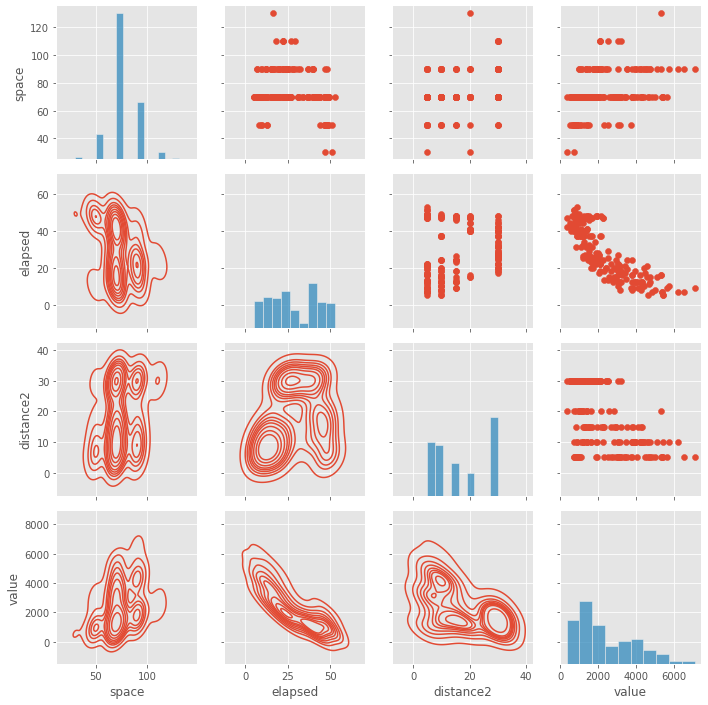

In [16]:
g = sns.PairGrid(df2)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot) # kde: kernel density estimation
g = g.map_diag(sns.histplot, kde=False) # 対角線上にヒストグラムを表示

# 最後の行のグラフ4つ（縦軸がvalue）に着目すると、
# space: 上方向に強くでているので、おおよそ正の相関になりそう　→ 敷地面積が広ければ、価格が高くなる傾向がある
# elapsed: 綺麗に負の相関になっている　→ 築年数が経っていれば、価格が安くなる傾向がある
# distance: おおよそ負の相関　→ 駅からの距離が長いほど、価格が安くなる傾向がある

In [17]:
stan_model = """
// 重回帰分析なので、データを変数分設定する
data {
  int N;
  real elapsed[N];
  real dis[N];
  real space[N];
  real Y[N];
}

parameters {
  real d; // distance
  real s; // space
  real e; // elapsed
  real b; // 切片
  real<lower=0> sigma;
}

model {
  real mu;
  for (n in 1:N) {
    // 下記が重回帰分析の式
    mu = e * elapsed[n] + d * dis[n] + s * space[n] + b;
    // Y（値段）が上記回帰直線の正規分布に従う
    Y[n] ~ normal(mu, sigma);
  }
}

"""

In [18]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_118f5acdb44be494f22afb55c57af67a NOW.


In [19]:
stan_data = {"N": df.shape[0], "elapsed":df["elapsed"], "dis":df["distance2"], "space":df["space"], "Y":df["value"]}

In [20]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=4, seed=123)

In [21]:
fit

# Rhatが1.0なので各パラメータが収束している
# d: meanを見ると、負の値なので、距離が遠くなればなるほど価格が下がっていくことがわかる
# s: 正の値なので、1平米増える毎に、25万円ほど増えていくことがわかる
# e: 築年数が1年増える毎に、68万円ほど減っていくことがわかる
# また、いずれの変数もse_meanが小さな値なので、ある程度信頼できる結果になった

Inference for Stan model: anon_model_118f5acdb44be494f22afb55c57af67a.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d     -57.74    0.09   5.04 -67.65 -61.08 -57.72 -54.37 -47.82   3312    1.0
s      24.64    0.07   3.57  17.45   22.3  24.63  27.05  31.61   2389    1.0
e     -67.62    0.07   3.78 -75.02  -70.1 -67.64 -65.08 -60.09   2823    1.0
b     3433.7    6.16 299.97 2848.0 3230.4 3431.6 3636.5 4038.9   2375    1.0
sigma 637.22    0.46  32.87 577.01 614.22 636.12 658.15 706.55   5042    1.0
lp__   -1363    0.04   1.61  -1367  -1364  -1363  -1362  -1361   2016    1.0

Samples were drawn using NUTS at Mon Sep 21 20:22:46 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

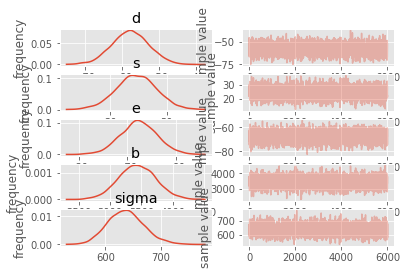

In [22]:
fig = fit.plot()

# 図で表しても、比較的左右に偏りがなく、綺麗な結果になっている